<a href="https://colab.research.google.com/github/TapasKumarDutta1/anomaly-detection/blob/main/Working_Demo_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/TapasKumarDutta1/anomaly-detection.git

Cloning into 'anomaly-detection'...
remote: Enumerating objects: 918, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 918 (delta 64), reused 151 (delta 54), pack-reused 747
Receiving objects: 100% (918/918), 7.22 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (429/429), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/connected-robotics-submission/ezyZip.zip", 'r') as zObject:
    zObject.extractall(
        path="/content")

In [4]:
cd /content/anomaly-detection

/content/anomaly-detection


## Task 1

In [5]:
#Task1
import glob
from tqdm import tqdm
from segmentation import matchTemplates
import cv2
import numpy as np
import os
import sys

os.mkdir("/content/segmented")

template_image = cv2.imread("/content/color/OK1/No.000_OK.bmp")

template = template_image[180:1100,:700,:]

for path in tqdm(glob.glob("/content/color/*/*.bmp")):
  
  image = cv2.imread(path)
  #slide the template over the images and compare similarity using cv2.TM_CCOEFF_NORMED
  #cv2.TM_CCOEFF_NORMED works similar to cosine similarity as in (A . B) / (|A| + |B|)
  Hits = matchTemplates(template, image, N_object=8,score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
  
  for en,(_,i) in enumerate(Hits.iterrows()):
    
    y,x,h,w = i['BBox']
    part = image[x : x + w, y : y + h, :]
    name = path.split("/")
    typ, num = name[-2],name[-1]
    part = image[x : x + w, y : y + h, :]
    cv2.imwrite("/content/segmented/" + typ + "_" + ".".join( num.split(".")[:-1]) + "_" + str(en) + ".png", part)

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


## Task 2

In [6]:
# copy annotated data from drive to local
from distutils.dir_util import copy_tree
copy_tree("/content/drive/MyDrive/connected-robotics-submission/annotate_after_segment", "/content/annotated")

['/content/annotated/template.png',
 '/content/annotated/.DS_Store',
 '/content/annotated/ok1/OK1_No.002_OK_5.png',
 '/content/annotated/ok1/OK1_No.002_OK_6.png',
 '/content/annotated/ok1/OK1_No.003_OK_0.png',
 '/content/annotated/ok1/OK1_No.003_OK_1.png',
 '/content/annotated/ok1/OK1_No.000_OK_6.png',
 '/content/annotated/ok1/OK1_No.000_OK_7.png',
 '/content/annotated/ok1/OK1_No.001_OK_2.png',
 '/content/annotated/ok1/OK1_No.002_OK_3.png',
 '/content/annotated/ok1/OK1_No.002_OK_1.png',
 '/content/annotated/ok1/OK1_No.000_OK_0.png',
 '/content/annotated/ok1/OK1_No.003_OK_4.png',
 '/content/annotated/ok1/OK1_No.000_OK_1.png',
 '/content/annotated/ok1/OK1_No.000_OK_5.png',
 '/content/annotated/ok1/OK1_No.001_OK_4.png',
 '/content/annotated/ok1/OK1_No.002_OK_7.png',
 '/content/annotated/ok1/OK1_No.001_OK_3.png',
 '/content/annotated/ok1/OK2_No.004_OK_0.png',
 '/content/annotated/ok1/OK1_No.003_OK_6.png',
 '/content/annotated/ok1/OK1_No.000_OK_4.png',
 '/content/annotated/ok1/OK1_No.000_OK

In [7]:
cd /content/anomaly-detection/HistAuGAN

/content/anomaly-detection/HistAuGAN


In [8]:
#train HistAuGAN(initialized from weights given in original respository) on ok images for augmentation

!python train.py --dataroot /content/annotated/ok1 --name GAN-ok --result_dir /content --num_domains 5 --batch_size 4 --n_ep 5 --img_save_freq 1 --model_save_freq 1 --resize_size 768 --resume /content/drive/MyDrive/connected-robotics-submission/HistAugGAN-starting-weights.pth --nThreads 2
#actual training needed was 1200 epochs

2023-04-20 14:44:57.758816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 14:44:59.084743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
hi

--- load options ---
batch_size: 4
concat: 1
crop_size: 216
d_iter: 3
dataroot: /content/annotated/ok1
dis_norm: None
dis_scale: 3
dis_spectral_norm: False
display_dir: ./logs
display_freq: 10
gpu: 0
img_save_freq: 1
input_dim: 3
lambda_cls: 1.0
lambda_cls_G: 5.0
lambda_rec: 10
lr_policy: step
model_save_freq: 1
nThreads: 2
n_ep: 5
n_ep_decay: 600
name: GAN-ok
no_display_img: False
no_flip: False
num_domains: 5
phase: train
resize_size: 768
result_dir: /content
resume: /content/drive/MyDrive/connected-robotics-submission/HistAugGAN-starting-weights.pth
t

In [16]:
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from model import MD_multi
from augmentations import opts
from augmentations import generate_hist_augs
import glob
from tqdm import tqdm

#load trained weights of HistAuGAN model
model = MD_multi(opts).to("cuda")
model.resume("/content/drive/MyDrive/connected-robotics-submission/GAN_stage_1_wts.pth", train=False)
model.eval()

#encode each ok image and recreate image after adding noise
os.mkdir("/content/GANs-stage1")
for path in tqdm(glob.glob("/content/annotated/ok1/*")):
    img = torch.from_numpy(np.transpose(cv2.imread(path),(2,0,1))/255).float().to('cuda')


    z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))
    out = generate_hist_augs(img, 0, model, None, same_attribute=False, new_domain=0, stats=None, device='cuda')

    img1=out.add(1).div(2).permute(1, 2, 0).cpu().numpy()
    name=path.split("/")[-1]
    name=name.split(".")[0]+name.split(".")[1]+"_stage1."+name.split(".")[2]
    cv2.imwrite("/content/GANs-stage1/"+name,255*img1[:,:,::-1])


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


In [18]:
import shutil
os.mkdir("/content/train-stage-1")

#combine GAN augmented and ok images for anomaly detection training
for src in glob.glob("/content/GANs/*"):
    shutil.copyfile(src, "/content/train-stage-1/"+src.split("/")[-1])
for src in glob.glob("/content/annotated/ok1/*"):
    shutil.copyfile(src, "/content/train-stage-1/"+src.split("/")[-1])

In [22]:
cd ..

/content/anomaly-detection


In [24]:
pip install pytorch_lightning==1.9.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
#train anomaly detection on combined GAN augmented and ok images
!python anomaly_detection.py --phase train --dataset_path /content/train-stage-1 --project_path  /content/anomaly-stage-1-GAN --batch_size 1 --num_epochs 1

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_

## Task 3

Defect Types and quantitative evaluation
### 1. Text Defect:
        Definition: Texts are blurry
        Condition: Anomaly map covers text region
### 2. Structural Defect:
        Definition: Structures are malformed
        Condition: Anomaly map covers structure edges
### 3. Color/Scratch Defect:
        Definition: Color of region different from surrounding
        Condition: Anomaly map present within structure 

### Quantitative Evaluation: 
  
Area covered by observable largest defect 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average

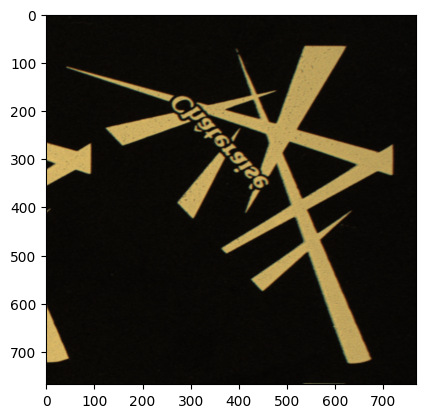

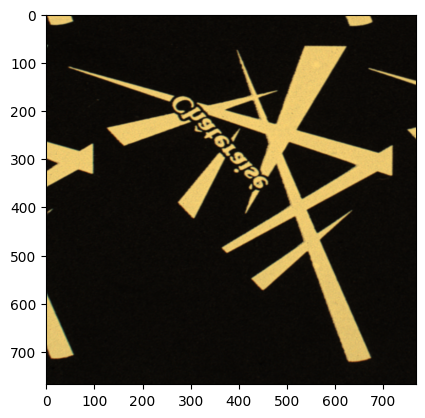

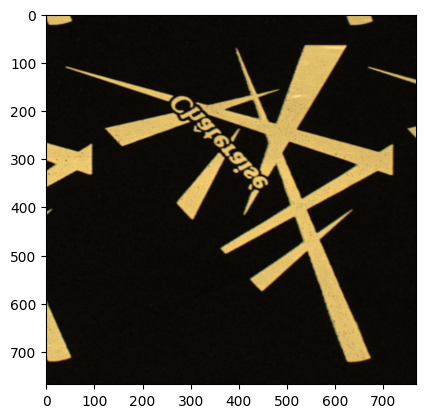

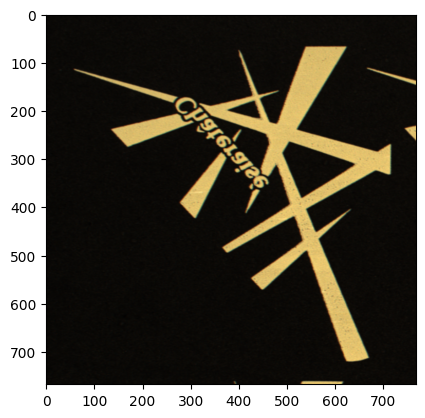

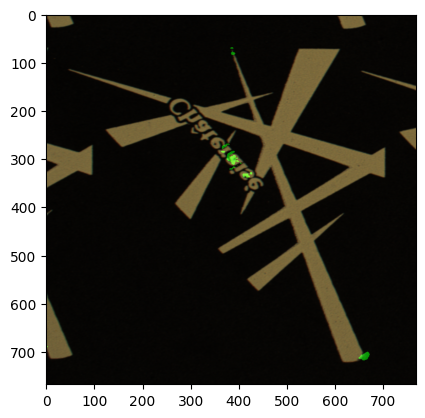

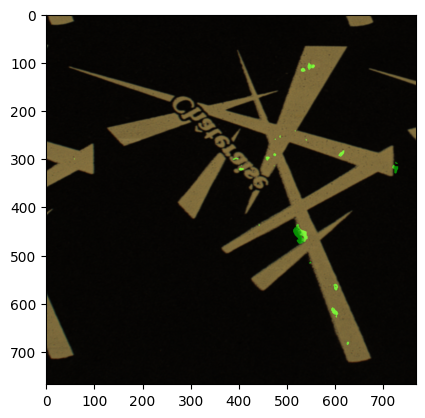

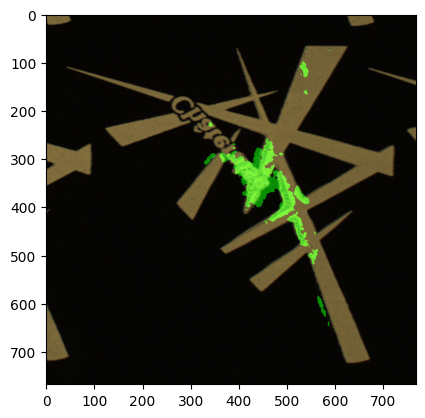

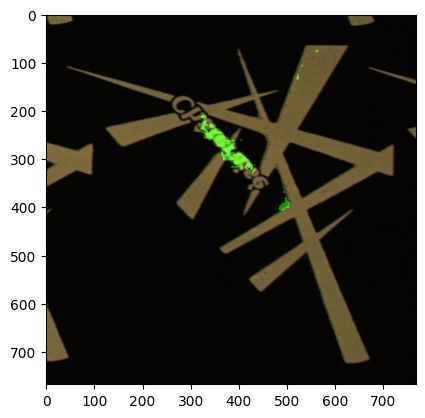

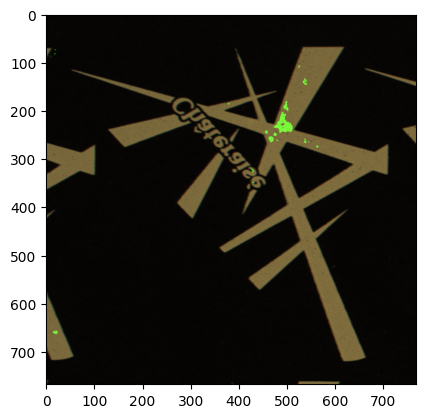

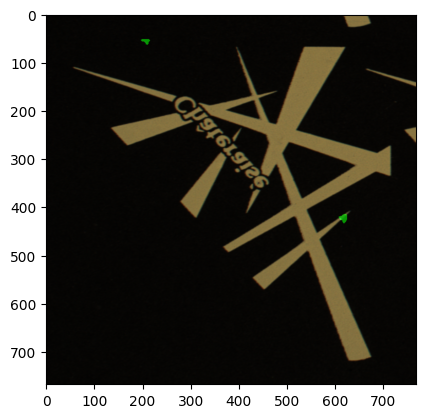

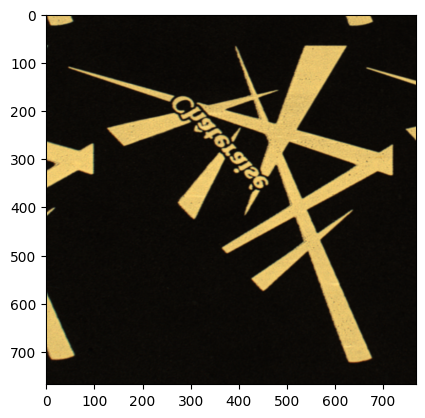

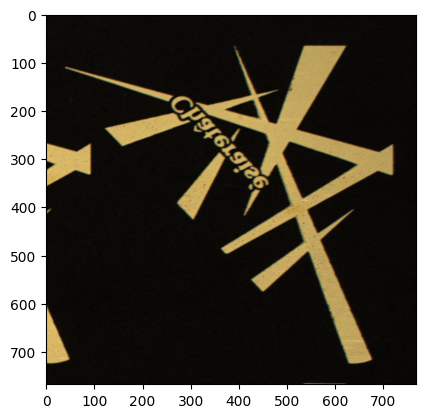

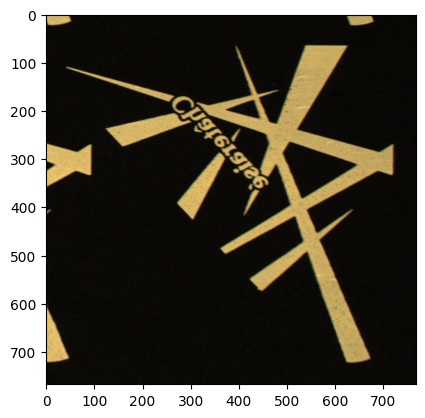

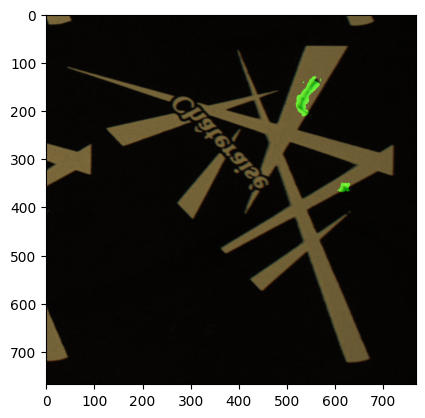

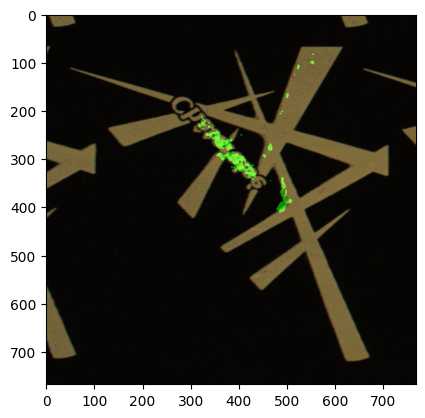

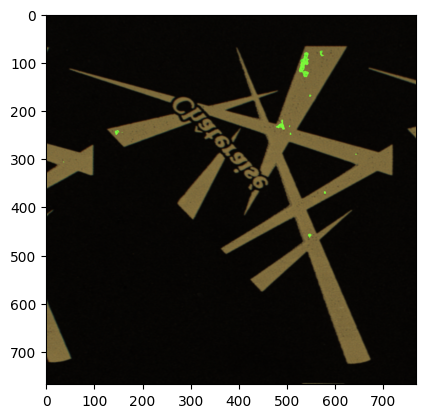

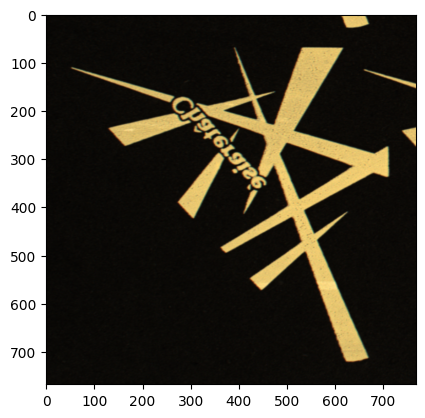

In [25]:
#showing anomaly map for nok images
#The model performs well for structural and Text defect but struggle with color/scratch defects
from get_anomaly_map import *
get_anomaly_map("/content/annotated/nok1","/content/drive/MyDrive/connected-robotics-submission/student-teacher-stage-1-with-GAN.ckpt","stage-1-GAN")

## Task 4: Anomaly Detection Given a Single Good Template


In [ ]:
cd /content/anomaly-detection/HistAuGAN

In [ ]:
#Set template as one class and ok images as another call with template being selected 10% and one of ok images selected 90% for training
#Select templae image more times resulted in output images not having noise while selecting template less times resulted in deformed images
!python train.py --template /content/annotated/template.png --dataroot /content/annotated/ok1 --name GAN-template --result_dir /content --num_domains 5 --batch_size 4 --n_ep 5 --img_save_freq 1 --model_save_freq 1 --resize_size 768 --resume /content/drive/MyDrive/connected-robotics-submission/HistAugGAN-starting-weights.pth --nThreads 2

In [ ]:
#load trained weights of HistAuGAN model
model = MD_multi(opts).to("cuda")
model.resume("/content/drive/MyDrive/connected-robotics-submission/GAN_stage_2_wts.pth", train=False)
model.eval()
os.mkdir("/content/GANs-stage2")

#extract features from images of ok class and recreate template image from them
for path in tqdm(glob.glob("/content/annotated/ok1/*")):
    img = torch.from_numpy(np.transpose(cv2.imread(path),(2,0,1))/255).float().to('cuda')


    z_content = model.enc_c(img.sub(0.5).mul(2).unsqueeze(0))
    out = generate_hist_augs(img, 0, model, None, same_attribute=False, new_domain=1, stats=None, device='cuda')

    img1=out.add(1).div(2).permute(1, 2, 0).cpu().numpy()
    name=path.split("/")[-1]
    name=name.split(".")[0]+name.split(".")[1]+"_stage2."+name.split(".")[2]
    cv2.imwrite("/content/GANs-stage2/"+name,255*img1[:,:,::-1])

In [ ]:
os.mkdir("/content/train-stage-2")
for src in glob.glob("/content/GANs/*"):
    shutil.copyfile(src, "/content/train-stage-2/"+src.split("/")[-1])
for src in glob.glob("/content/annotated/ok1/*"):
    shutil.copyfile(src, "/content/train-stage-2/"+src.split("/")[-1])
for src in glob.glob("/content/GANs-stage2/*"):
    shutil.copyfile(src, "/content/train-stage-2/"+src.split("/")[-1])

In [ ]:
cd ..

In [ ]:
#train anomaly detection model on ok images reconstructed, ok images reconstructed as templae image and ok images
!python anomaly_detection.py --wts template --phase train --dataset_path /content/train-stage-2 --project_path  /content/store2 --batch_size 1 --num_epochs 1

In [ ]:
#get anomaly maps for nok images
get_anomaly_map("/content/annotated/nok1","/content/drive/MyDrive/connected-robotics-submission/student-teacher-stage-2-with-GAN.ckpt","stage-2-GAN")